In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
import matplotlib as mpl
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from compiler.ast import flatten
from sklearn.neighbors import NearestNeighbors
from itertools import groupby
import math
import networkx as nx
import gc
import psutil
import scipy.stats
#import Thestral
from scipy.stats.mstats import gmean

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import community
import matplotlib.gridspec as gridspec
import random
import itertools



/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.


In [2]:



#常用函数
def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def Read(File):
    return pd.read_table(File,sep='\t',index_col=0)

def ReadBed(File):
    Bed=pd.read_table(File,sep='\t',index_col=None,header=None)
    Bed.index=Bed[3]
    return Bed

def Save(DF,File):
    DF.to_csv(File,sep='\t')

def SaveBed(Bed,File):
    Bed.to_csv(File,sep='\t',index=False,header=False)
    
def GetState(i):
    if 'Norm' in i: return 'Norm'
    if 'Arm' in i: return 'Arm'
    if 'Back' in i:return 'Back'





In [3]:
#文件位置
CountF='/Users/liuqian/Documents/A_SSC_project/All_Celltype/PeakCount.QNorm_Normalized.log2.txt'
BedF='/Users/liuqian/Documents/A_SSC_project/All_Celltype/NormSScPeaks.bed'

CountDF=Read(CountF)
BedDF=ReadBed(BedF)



In [4]:
#ColorDF
ClusterColorsDict={'CD4':'#EC2427','CD8':'#F15E25','Mac':'#231F20','Fib':'#3B54A4','EC':'#EB0D8C','DC':'#6CBE46','LC':'#34C5F4','KC':'#F6EC13','CD31':'#EB0D8C','pDC':'w'}          
ClusterMarkerDict={'Norm':'o','Back':'^','Arm':'s'}
StateColorDict={'Norm':'#1B5B9C','Arm':'#C94540','Back':'coral','Norm-Arm-Back':'#8B8C8F','Arm-Back':'#4D2A7C','Norm-Arm':'#675EA9','Norm-Back':'#4B86C6'} 


AllSampleColorDF=pd.DataFrame({'Celltype':[ClusterColorsDict[i.split('_')[0]] for i in list(CountDF)]}, index=list(CountDF))              
AllSampleColorDF['State']=[StateColorDict[GetState(i)] for i in AllSampleColorDF.index]



In [5]:
#对每个细胞类型筛选Norm,Back,Arm差异的Peak,筛选NormSpecific,NormBackSpecific,BackSpecific,BackArmSpecific,ArmSpecific,NormArmSpecific                       
def BarPlot(DF,ColorDict,Dir,Num):
    YOrder=list(DF.index)
    plt.style.use('seaborn-white')
    fig1=plt.figure(figsize=(3,6))
    ax1=fig1.add_axes([0.15,0.2,0.8,0.75])
    X=range(1,len(list(DF))+1)
    for y in range(len(YOrder)):
        Y=YOrder[y]
        if y==0:
            Bottom=[0]*len(list(DF))
        else:
            Bottom=DF.loc[YOrder[:y]].apply(sum,axis=0)
        print Bottom
        color=ColorDict[Y]
        ax1.bar(X,list(DF.loc[Y]),bottom=Bottom,color=color,tick_label=Y,width=0.95)
    plt.xticks(X,list(DF),fontsize=20)
    ax1.set_xticklabels(list(DF),rotation='vertical')
    ax1.tick_params(labelsize=20,length=5,direction='out')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    plt.title(Num,fontsize=15)
    fig1.savefig(os.path.join(Dir,'Ratio.BarPlot.pdf'))
    plt.show()
    
def FindVarPeak(DF,BedDF,outDir,f,r1,r2):
    ColorDict={'Norm':'#1B5B9C','Arm':'#C94540','Back':'coral','Norm-Arm-Back':'#8B8C8F','Arm-Back':'#4D2A7C','Norm-Arm':'#675EA9','Norm-Back':'#4B86C6'}
    def Range(L):return max(L)-min(L)
    def Range2(L):   
        SL=sorted(L)
        return np.mean(SL[-2:])-np.mean(SL[:2])
    DF=DF[DF.apply(max,axis=1)>4]
    print len(DF)
    H=[]
    for s in ['Norm','Back','Arm']:
        H=H+[i for i in list(DF) if s in i]
    print H
    DF=DF[H]
    ZDF=DF.apply(scipy.stats.zscore,axis=1)
    ColorDF=pd.DataFrame({'State':[ColorDict[GetState(i)] for i in list(DF)]},index=list(DF))
    Order=['Norm','Norm-Back','Back','Arm-Back','Arm','Norm-Arm']
    PieDF=pd.DataFrame({'Color':[ColorDict[i] for i in Order]},index=Order)
    PieDF2=pd.DataFrame({'Color':['#37006A','#006D94','#BF5500']},index=['Com_Norm_Arm','Com_Norm_Back','Com_Arm_Back'])
    Num=[]
    Peak=[]
    ZPeak=[]
    for st in Order:
        print st
        I=[]
        O=[]
        for i in st.split('-'):
            for h in list(DF):
                if i in h: 
                    I.append(h)
        print I
        IN=DF[I]
        ZIN=ZDF[I]
        OUT=DF[[i for i in list(DF) if i not in I]]
        print list(OUT)
        INM=IN.apply(np.mean,axis=1)
        ZINM=ZIN.apply(np.mean,axis=1)
        OUTM=OUT.apply(np.mean,axis=1)
        INR=IN.apply(Range,axis=1)
        
        print INM
        print OUTM
        
        OUTCov=OUT.apply(scipy.stats.variation,axis=1)
        fdc=INM-OUTM
        if len(list(OUT))>3:
            OUTR=OUT.apply(Range2,axis=1)
        else:
            OUTR=OUT.apply(Range,axis=1)
            
        Final=INM[(fdc>f)&(INR<r1)&(OUTR<r2)].sort_values()
        print len(Final)
        FinalBed=BedDF.loc[Final.index]
        SaveBed(FinalBed,os.path.join(outDir,st+'.specificPeaks.bed'))
        Save(DF.loc[Final.index],os.path.join(outDir,st+'specificPeaks.count.txt'))
        Num.append(len(Final))
        peaks=[i for i in list(Final.index) if i not in Peak]
        zpeaks=list(ZINM.loc[peaks].sort_values().index)
        print len(peaks)
        Peak=Peak+peaks
        ZPeak=ZPeak+zpeaks
        print len(Peak)
    
    PieDF['Num']=Num
    PieDF2['Num']=[PieDF['Num']['Norm-Arm']+PieDF['Num']['Back'],PieDF['Num']['Norm-Back']+PieDF['Num']['Arm'],PieDF['Num']['Arm-Back']+PieDF['Num']['Norm']]
    FinalDF=DF.loc[Peak]
    Save(FinalDF,os.path.join(outDir,'All.specificPeaks.count.txt'))
    SaveBed(BedDF.loc[Peak],os.path.join(outDir,'All.specificPeaks.bed'))
    #Heatmap
    ZFinalDF=FinalDF.apply(scipy.stats.zscore,axis=1)
    fig=sns.clustermap(ZFinalDF.loc[ZPeak],figsize=(0.4*len(list(FinalDF)),6),col_colors=ColorDF,col_cluster=False,row_cluster=False,cmap='Spectral_r',vmax=-1.5,vmin=1.5)
    fig.savefig(os.path.join(outDir,'All.specificPeaks.Zcount.Heatmap.pdf'))
    fig=sns.clustermap(FinalDF,figsize=(0.4*len(list(FinalDF)),6),col_colors=ColorDF,col_cluster=False,row_cluster=False,cmap='Spectral_r',vmax=2,vmin=8)
    fig.savefig(os.path.join(outDir,'All.specificPeaks.count.Heatmap.pdf'))    
    
    #pie plot
    fig5=plt.figure(figsize=(3.5,3.5))
    ax5=fig5.add_axes([0.15,0.15,0.8,0.8]) 
    #patches1,texts1=ax5.pie(PieDF['Num'],colors=[ColorDict[i] for i in PieDF.index],autopct='%1.1f%%') 
    #ax5.legend(patches1,PieDF.index, loc='best',fancybox=False,edgecolor='none',fontsize='x-large')
    ax5.pie(PieDF['Num'],labels=list(PieDF.index),colors=[ColorDict[i] for i in PieDF.index],autopct='%1.1f%%',pctdistance=0.7,textprops={'color':'w','fontsize':10}) 
    ax5.legend(loc='upper right',fancybox=False,edgecolor='none',fontsize='large')
    fig5.savefig(os.path.join(outDir,'All.specificPeaks.count.PiePlot.pdf'))
    plt.show()
    
    #pairwise
    fig6=plt.figure(figsize=(3.5,3.5))
    ax6=fig6.add_axes([0.15,0.15,0.8,0.8]) 
    #patches1,texts1=ax5.pie(PieDF['Num'],colors=[ColorDict[i] for i in PieDF.index],autopct='%1.1f%%') 
    #ax5.legend(patches1,PieDF.index, loc='best',fancybox=False,edgecolor='none',fontsize='x-large')
    ax6.pie(PieDF2['Num'],labels=list(PieDF2.index),colors=list(PieDF2['Color']),autopct='%1.1f%%',pctdistance=0.7,textprops={'color':'w','fontsize':10}) 
    ax6.legend(loc='upper right',fancybox=False,edgecolor='none',fontsize='large')
    fig6.savefig(os.path.join(outDir,'All.Comm.count.PiePlot.pdf'))
    plt.show()  
    return FinalDF

    
    
    

In [8]:
CD4Dir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/CD4'
CD8Dir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/CD8'
DCDir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/DC'
FibDir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/Fib'
Mkdir(CD4Dir)
Mkdir(CD8Dir)
Mkdir(DCDir)
Mkdir(FibDir)
CD4DF=CountDF[[i for i in list(CountDF) if 'CD4' in i]]
CD8DF=CountDF[[i for i in list(CountDF) if 'CD8' in i]]
DCDF=CountDF[[i for i in list(CountDF) if i.split('_')[0]=='DC']]
FibDF=CountDF[[i for i in list(CountDF) if 'Fib' in i]]


52998
['DC_NormSkin_M_34', 'DC_NormSkin_M_21', 'DC_SSc_Back_F_1181', 'DC_SSc_Back_F_1183', 'DC_SSc_Arm_F_1181', 'DC_SSc_Arm_F_28', 'DC_SSc_Arm_M_25_combine']
Norm
['DC_NormSkin_M_34', 'DC_NormSkin_M_21']
['DC_SSc_Back_F_1181', 'DC_SSc_Back_F_1183', 'DC_SSc_Arm_F_1181', 'DC_SSc_Arm_F_28', 'DC_SSc_Arm_M_25_combine']
PeakID
NormSSc.2         5.250541
NormSSc.3         2.445574
NormSSc.4         3.664311
NormSSc.5         3.137007
NormSSc.7         4.793928
NormSSc.10        4.103450
NormSSc.12        4.605443
NormSSc.13        2.069385
NormSSc.15        4.914382
NormSSc.17        2.463992
NormSSc.18        5.575623
NormSSc.19        5.551257
NormSSc.20        3.087753
NormSSc.21        4.931670
NormSSc.22        4.418188
NormSSc.24        3.395551
NormSSc.25        4.361401
NormSSc.26        5.904618
NormSSc.27        3.772205
NormSSc.28        4.875012
NormSSc.29        3.148658
NormSSc.30        5.906292
NormSSc.31        3.148658
NormSSc.34        5.551257
NormSSc.35        2.287752
No

3966
3652
6708
Arm-Back
['DC_SSc_Arm_F_1181', 'DC_SSc_Arm_F_28', 'DC_SSc_Arm_M_25_combine', 'DC_SSc_Back_F_1181', 'DC_SSc_Back_F_1183']
['DC_NormSkin_M_34', 'DC_NormSkin_M_21']
PeakID
NormSSc.2         5.792120
NormSSc.3         3.090551
NormSSc.4         3.453649
NormSSc.5         3.921368
NormSSc.7         4.657434
NormSSc.10        3.155506
NormSSc.12        5.366954
NormSSc.13        3.165964
NormSSc.15        5.154388
NormSSc.17        3.462054
NormSSc.18        4.747143
NormSSc.19        5.768330
NormSSc.20        3.946597
NormSSc.21        4.808707
NormSSc.22        4.560542
NormSSc.24        3.341164
NormSSc.25        4.684394
NormSSc.26        6.037100
NormSSc.27        4.525763
NormSSc.28        4.861303
NormSSc.29        4.949140
NormSSc.30        6.094283
NormSSc.31        3.298622
NormSSc.34        5.310752
NormSSc.35        3.054271
NormSSc.36        4.953218
NormSSc.37        5.139820
NormSSc.38        5.696384
NormSSc.40        3.722426
NormSSc.41        4.504498
      

/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:977: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


1461
1154
7862
Arm
['DC_SSc_Arm_F_1181', 'DC_SSc_Arm_F_28', 'DC_SSc_Arm_M_25_combine']
['DC_NormSkin_M_34', 'DC_NormSkin_M_21', 'DC_SSc_Back_F_1181', 'DC_SSc_Back_F_1183']
PeakID
NormSSc.2         5.817022
NormSSc.3         3.672453
NormSSc.4         3.534026
NormSSc.5         3.457945
NormSSc.7         4.483672
NormSSc.10        3.297349
NormSSc.12        5.171747
NormSSc.13        2.899102
NormSSc.15        4.855630
NormSSc.17        3.338273
NormSSc.18        4.692428
NormSSc.19        5.147141
NormSSc.20        3.651092
NormSSc.21        4.881201
NormSSc.22        4.714690
NormSSc.24        3.714797
NormSSc.25        4.790924
NormSSc.26        6.260406
NormSSc.27        4.355925
NormSSc.28        4.838264
NormSSc.29        4.340679
NormSSc.30        5.994386
NormSSc.31        3.283850
NormSSc.34        4.813121
NormSSc.35        2.301784
NormSSc.36        5.463920
NormSSc.37        5.157958
NormSSc.38        5.481754
NormSSc.40        3.579839
NormSSc.41        4.320483
           

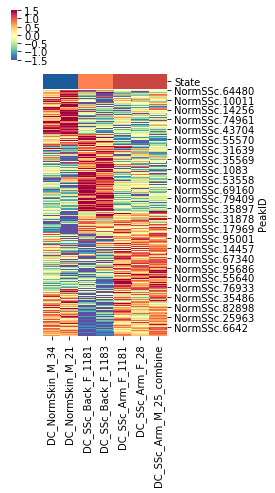

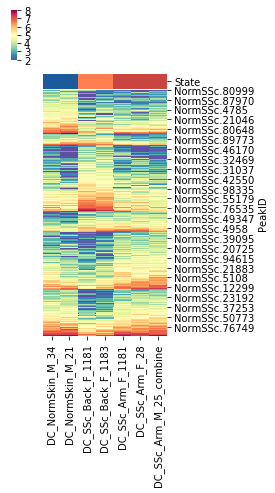

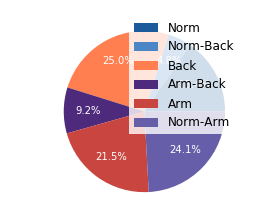

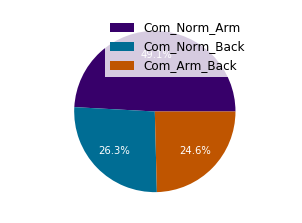

In [9]:
FinalDFDC=FindVarPeak(DCDF,BedDF,DCDir,0.8,1.5,1.5)

50431
['CD4_NormSkin_M_34', 'CD4_NormSkin_M_43', 'CD4_SSc_Back_F_1181', 'CD4_SSc_Back_F_1183', 'CD4_SSc_Back_M_29_combine', 'CD4_SSc_Arm_F_1181', 'CD4_SSc_Arm_F_28_combine', 'CD4_SSc_Arm_M_25_combine']
Norm
['CD4_NormSkin_M_34', 'CD4_NormSkin_M_43']
['CD4_SSc_Back_F_1181', 'CD4_SSc_Back_F_1183', 'CD4_SSc_Back_M_29_combine', 'CD4_SSc_Arm_F_1181', 'CD4_SSc_Arm_F_28_combine', 'CD4_SSc_Arm_M_25_combine']
PeakID
NormSSc.2         5.578934
NormSSc.3         1.115973
NormSSc.4         4.629381
NormSSc.5         3.849792
NormSSc.6         4.181893
NormSSc.8         0.991563
NormSSc.9         2.476733
NormSSc.10        4.749598
NormSSc.11        2.810128
NormSSc.12        4.973124
NormSSc.13        2.058384
NormSSc.15        3.691647
NormSSc.18        4.687191
NormSSc.19        4.909925
NormSSc.21        4.885103
NormSSc.24        4.659309
NormSSc.25        5.364325
NormSSc.26        5.465441
NormSSc.27        4.476743
NormSSc.28        3.153158
NormSSc.29        3.691647
NormSSc.30        5.80

348
331
1368
Arm-Back
['CD4_SSc_Arm_F_1181', 'CD4_SSc_Arm_F_28_combine', 'CD4_SSc_Arm_M_25_combine', 'CD4_SSc_Back_F_1181', 'CD4_SSc_Back_F_1183', 'CD4_SSc_Back_M_29_combine']
['CD4_NormSkin_M_34', 'CD4_NormSkin_M_43']
PeakID
NormSSc.2         6.364407
NormSSc.3         2.265520
NormSSc.4         5.311667
NormSSc.5         4.598225
NormSSc.6         4.830035
NormSSc.8         3.326098
NormSSc.9         2.261590
NormSSc.10        5.320395
NormSSc.11        3.502857
NormSSc.12        5.421727
NormSSc.13        3.241408
NormSSc.15        4.124551
NormSSc.18        5.684386
NormSSc.19        5.515751
NormSSc.21        5.578836
NormSSc.24        4.852599
NormSSc.25        5.228085
NormSSc.26        5.965976
NormSSc.27        4.849576
NormSSc.28        2.797800
NormSSc.29        4.026467
NormSSc.30        6.916937
NormSSc.31        4.037835
NormSSc.32        3.645396
NormSSc.33        3.369728
NormSSc.34        5.156278
NormSSc.35        3.894118
NormSSc.36        5.740676
NormSSc.37        

701
441
3397


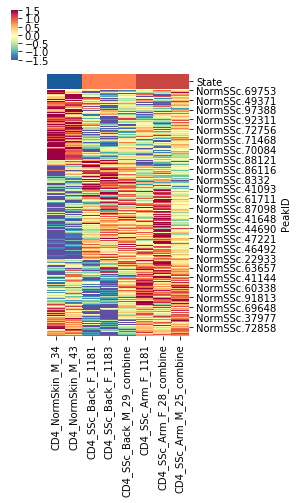

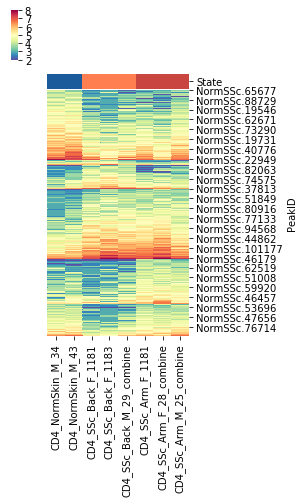

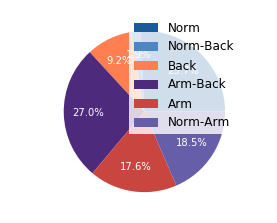

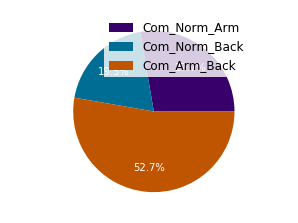

56120
['CD8_NormSkin_M_34', 'CD8_NormSkin_M_43', 'CD8_SSc_Back_F_1183', 'CD8_SSc_Back_M_25', 'CD8_SSc_Back_M_29_combine', 'CD8_SSc_Arm_F_1181', 'CD8_SSc_Arm_F_28_combine', 'CD8_SSc_Arm_M_25_combine']
Norm
['CD8_NormSkin_M_34', 'CD8_NormSkin_M_43']
['CD8_SSc_Back_F_1183', 'CD8_SSc_Back_M_25', 'CD8_SSc_Back_M_29_combine', 'CD8_SSc_Arm_F_1181', 'CD8_SSc_Arm_F_28_combine', 'CD8_SSc_Arm_M_25_combine']
PeakID
NormSSc.1         3.038099
NormSSc.2         5.737501
NormSSc.4         4.250528
NormSSc.5         4.175710
NormSSc.6         3.848054
NormSSc.7         2.248790
NormSSc.10        4.525947
NormSSc.12        5.036904
NormSSc.13        2.378325
NormSSc.14        0.740313
NormSSc.15        3.881306
NormSSc.16        1.887103
NormSSc.18        5.044249
NormSSc.19        5.325866
NormSSc.21        4.634155
NormSSc.24        4.027357
NormSSc.25        4.902406
NormSSc.26        5.583829
NormSSc.27        5.203807
NormSSc.29        4.207090
NormSSc.30        6.305331
NormSSc.31        4.423660

666
619
1368
Arm-Back
['CD8_SSc_Arm_F_1181', 'CD8_SSc_Arm_F_28_combine', 'CD8_SSc_Arm_M_25_combine', 'CD8_SSc_Back_F_1183', 'CD8_SSc_Back_M_25', 'CD8_SSc_Back_M_29_combine']
['CD8_NormSkin_M_34', 'CD8_NormSkin_M_43']
PeakID
NormSSc.1         3.635920
NormSSc.2         5.804015
NormSSc.4         4.774970
NormSSc.5         4.791275
NormSSc.6         3.766520
NormSSc.7         1.954618
NormSSc.10        4.764016
NormSSc.12        5.017210
NormSSc.13        3.376964
NormSSc.14        1.233382
NormSSc.15        3.623959
NormSSc.16        2.293252
NormSSc.18        5.588055
NormSSc.19        5.116638
NormSSc.21        5.173953
NormSSc.24        4.056156
NormSSc.25        5.046392
NormSSc.26        5.806102
NormSSc.27        5.011352
NormSSc.29        3.942187
NormSSc.30        6.264720
NormSSc.31        4.285061
NormSSc.34        4.621336
NormSSc.35        2.545212
NormSSc.36        5.164862
NormSSc.37        5.753934
NormSSc.38        5.684604
NormSSc.40        1.367592
NormSSc.41        4.

474
344
2755


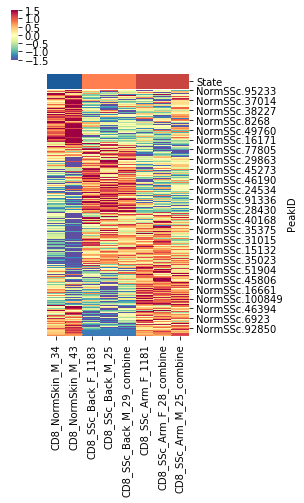

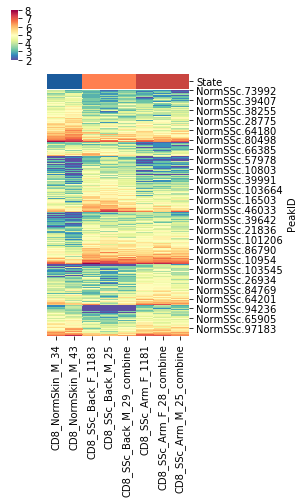

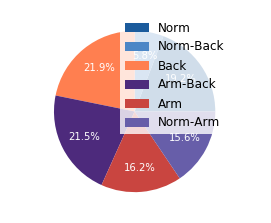

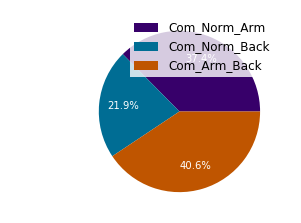

58893
['Fib_NormSkin_F_42', 'Fib_NormSkin_F_44', 'Fib_NormSkin_M_24', 'Fib_NormSkin_M_43', 'Fib_SSc_Back_F_1205', 'Fib_SSc_Back_M_29', 'Fib_SSc_Arm_F_1202', 'Fib_SSc_Arm_F_1205', 'Fib_SSc_Arm_M_25', 'Fib_SSc_Arm_M_29']
Norm
['Fib_NormSkin_F_42', 'Fib_NormSkin_F_44', 'Fib_NormSkin_M_24', 'Fib_NormSkin_M_43']
['Fib_SSc_Back_F_1205', 'Fib_SSc_Back_M_29', 'Fib_SSc_Arm_F_1202', 'Fib_SSc_Arm_F_1205', 'Fib_SSc_Arm_M_25', 'Fib_SSc_Arm_M_29']
PeakID
NormSSc.1         2.832733
NormSSc.2         5.997816
NormSSc.4         5.453502
NormSSc.5         3.467775
NormSSc.6         3.760864
NormSSc.8         2.824411
NormSSc.9         2.988274
NormSSc.10        4.492871
NormSSc.12        5.111059
NormSSc.13        3.161053
NormSSc.15        5.454419
NormSSc.16        3.424697
NormSSc.18        5.080824
NormSSc.19        5.762911
NormSSc.20        3.838681
NormSSc.21        4.726257
NormSSc.24        3.592267
NormSSc.25        4.869765
NormSSc.26        5.157380
NormSSc.27        4.344321
NormSSc.28     

312
298
1316
Arm-Back
['Fib_SSc_Arm_F_1202', 'Fib_SSc_Arm_F_1205', 'Fib_SSc_Arm_M_25', 'Fib_SSc_Arm_M_29', 'Fib_SSc_Back_F_1205', 'Fib_SSc_Back_M_29']
['Fib_NormSkin_F_42', 'Fib_NormSkin_F_44', 'Fib_NormSkin_M_24', 'Fib_NormSkin_M_43']
PeakID
NormSSc.1         3.856359
NormSSc.2         5.977475
NormSSc.4         5.069124
NormSSc.5         3.321182
NormSSc.6         2.781079
NormSSc.8         2.808961
NormSSc.9         3.218461
NormSSc.10        4.576435
NormSSc.12        5.220687
NormSSc.13        2.960700
NormSSc.15        5.911117
NormSSc.16        4.024370
NormSSc.18        5.064201
NormSSc.19        5.885089
NormSSc.20        3.653352
NormSSc.21        4.524667
NormSSc.24        3.624733
NormSSc.25        5.115466
NormSSc.26        4.908189
NormSSc.27        3.664398
NormSSc.28        3.568711
NormSSc.29        4.098503
NormSSc.30        6.811108
NormSSc.31        3.296101
NormSSc.34        5.837968
NormSSc.36        5.033518
NormSSc.37        5.663449
NormSSc.38        6.103367
N

228
210
2009


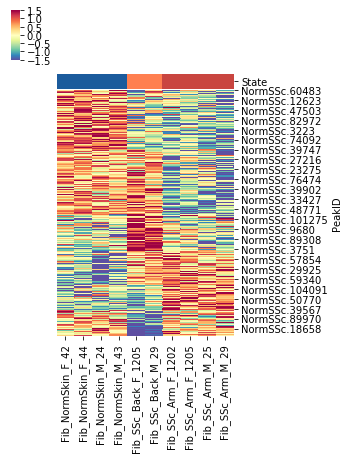

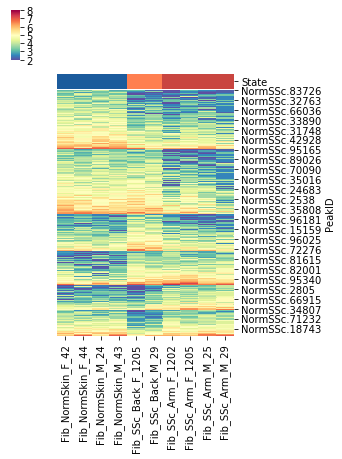

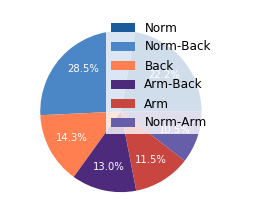

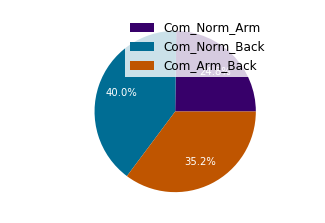

In [37]:
FinalDFCD4=FindVarPeak(CD4DF,BedDF,CD4Dir,0.8,1.5,1.5)
FinalDFCD8=FindVarPeak(CD8DF,BedDF,CD8Dir,0.8,1.5,1.5)
FinalDFFib=FindVarPeak(FibDF,BedDF,FibDir,0.8,1.5,1.5)


48766
['CD31_NormSkin_F_42', 'CD31_NormSkin_F_44', 'CD31_NormSkin_M_43', 'CD31_SSc_Back_F_1205', 'CD31_SSc_Arm_F_1205']
Norm
['CD31_NormSkin_F_42', 'CD31_NormSkin_F_44', 'CD31_NormSkin_M_43']
['CD31_SSc_Back_F_1205', 'CD31_SSc_Arm_F_1205']
PeakID
NormSSc.1         2.624217
NormSSc.2         6.547657
NormSSc.4         5.482641
NormSSc.5         4.142857
NormSSc.6         4.250427
NormSSc.10        5.386880
NormSSc.12        5.470368
NormSSc.13        3.726329
NormSSc.15        5.968760
NormSSc.17        2.779348
NormSSc.18        5.603125
NormSSc.19        6.236933
NormSSc.20        4.190384
NormSSc.21        4.800839
NormSSc.24        4.829565
NormSSc.25        5.577163
NormSSc.26        5.794153
NormSSc.27        3.709264
NormSSc.29        4.748456
NormSSc.30        7.244434
NormSSc.31        4.704159
NormSSc.34        5.846588
NormSSc.36        6.462859
NormSSc.37        4.341683
NormSSc.38        6.449019
NormSSc.41        6.126015
NormSSc.43        6.624423
NormSSc.44        6.4053

/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:977: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


3683
3683
3683
Norm-Back
['CD31_NormSkin_F_42', 'CD31_NormSkin_F_44', 'CD31_NormSkin_M_43', 'CD31_SSc_Back_F_1205']
['CD31_SSc_Arm_F_1205']
PeakID
NormSSc.1         3.363354
NormSSc.2         6.258822
NormSSc.4         5.586459
NormSSc.5         3.808982
NormSSc.6         4.014084
NormSSc.10        5.145750
NormSSc.12        5.476298
NormSSc.13        3.496586
NormSSc.15        5.408075
NormSSc.17        2.084511
NormSSc.18        5.501061
NormSSc.19        6.051222
NormSSc.20        3.911183
NormSSc.21        4.426893
NormSSc.24        4.970253
NormSSc.25        5.422502
NormSSc.26        5.557206
NormSSc.27        3.663931
NormSSc.29        4.772933
NormSSc.30        7.100114
NormSSc.31        4.671553
NormSSc.34        5.528375
NormSSc.36        5.952733
NormSSc.37        3.958101
NormSSc.38        6.254048
NormSSc.41        5.737945
NormSSc.43        6.267035
NormSSc.44        5.505821
NormSSc.46        4.884013
NormSSc.49        6.154143
                    ...   
NormSSc.104164  

2090
691
15182
Arm
['CD31_SSc_Arm_F_1205']
['CD31_NormSkin_F_42', 'CD31_NormSkin_F_44', 'CD31_NormSkin_M_43', 'CD31_SSc_Back_F_1205']
PeakID
NormSSc.1         5.526476
NormSSc.2         6.346050
NormSSc.4         5.893972
NormSSc.5         4.837004
NormSSc.6         4.678334
NormSSc.10        5.381895
NormSSc.12        6.238183
NormSSc.13        4.166192
NormSSc.15        5.859137
NormSSc.17        4.400284
NormSSc.18        6.427045
NormSSc.19        6.121594
NormSSc.20        3.562420
NormSSc.21        5.231054
NormSSc.24        3.158698
NormSSc.25        4.909126
NormSSc.26        5.929637
NormSSc.27        3.371397
NormSSc.29        4.287981
NormSSc.30        6.623584
NormSSc.31        4.166192
NormSSc.34        5.279368
NormSSc.36        6.060067
NormSSc.37        4.041341
NormSSc.38        6.288839
NormSSc.41        5.929637
NormSSc.43        6.318989
NormSSc.44        6.650885
NormSSc.46        4.753644
NormSSc.49        6.373017
                    ...   
NormSSc.104164    0.00

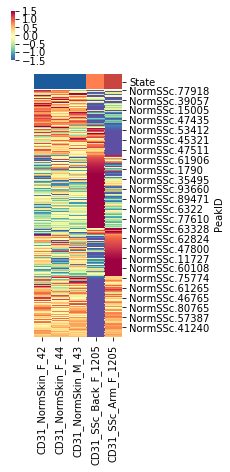

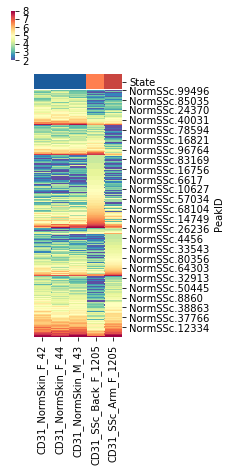

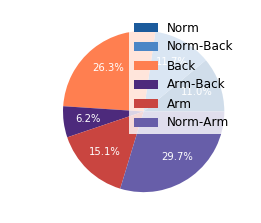

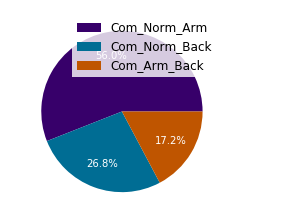

In [8]:

ECDir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/CD31_EC'
Mkdir(ECDir)
ECDF=CountDF[[i for i in list(CountDF) if 'CD31' in i]]
FinalDFEC=FindVarPeak(ECDF,BedDF,ECDir,0.8,1.5,1.5)



47249
['Mac_NormSkin_M_34', 'Mac_SSc_Back_F_1183', 'Mac_SSc_Arm_F_1181', 'Mac_SSc_Arm_F_1183']
Norm
['Mac_NormSkin_M_34']
['Mac_SSc_Back_F_1183', 'Mac_SSc_Arm_F_1181', 'Mac_SSc_Arm_F_1183']
PeakID
NormSSc.2         5.630373
NormSSc.4         4.701730
NormSSc.5         2.120630
NormSSc.6         3.049469
NormSSc.8         0.000000
NormSSc.9         1.840522
NormSSc.10        4.428604
NormSSc.11        1.840522
NormSSc.12        5.497805
NormSSc.13        2.462478
NormSSc.15        5.497805
NormSSc.16        2.120630
NormSSc.17        1.840522
NormSSc.18        4.647877
NormSSc.19        5.427824
NormSSc.20        3.556729
NormSSc.21        4.235513
NormSSc.24        3.049469
NormSSc.25        4.542402
NormSSc.26        4.701730
NormSSc.27        2.462478
NormSSc.28        3.213980
NormSSc.29        4.169925
NormSSc.30        5.958519
NormSSc.31        3.948775
NormSSc.34        4.485127
NormSSc.36        4.987363
NormSSc.37        3.556729
NormSSc.38        5.630373
NormSSc.41        4.

2735
1971
9495
Arm-Back
['Mac_SSc_Arm_F_1181', 'Mac_SSc_Arm_F_1183', 'Mac_SSc_Back_F_1183']
['Mac_NormSkin_M_34']
PeakID
NormSSc.2         6.324232
NormSSc.4         5.834024
NormSSc.5         3.745313
NormSSc.6         4.130717
NormSSc.8         3.994646
NormSSc.9         3.455467
NormSSc.10        5.478183
NormSSc.11        2.728382
NormSSc.12        5.360888
NormSSc.13        3.697703
NormSSc.15        5.734768
NormSSc.16        2.636929
NormSSc.17        3.478220
NormSSc.18        5.959085
NormSSc.19        7.176680
NormSSc.20        5.077015
NormSSc.21        5.508902
NormSSc.24        4.152925
NormSSc.25        5.543507
NormSSc.26        6.051710
NormSSc.27        3.396310
NormSSc.28        3.016743
NormSSc.29        4.829176
NormSSc.30        7.283877
NormSSc.31        4.562502
NormSSc.34        5.526079
NormSSc.36        6.878600
NormSSc.37        4.760543
NormSSc.38        7.226605
NormSSc.41        6.236823
                    ...   
NormSSc.104174    6.023929
NormSSc.104175 

4015
2468
18337


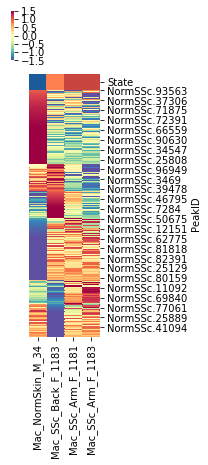

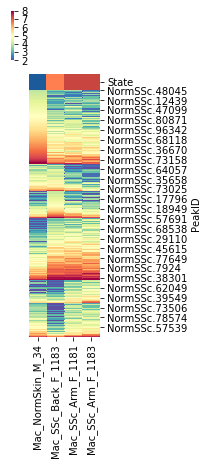

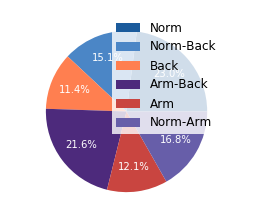

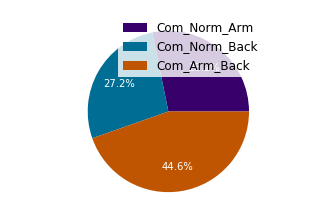

In [10]:
MacDir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/Mac'
Mkdir(MacDir)
MacDF=CountDF[[i for i in list(CountDF) if 'Mac' in i]]
FinalDFMac=FindVarPeak(MacDF,BedDF,MacDir,0.8,1.5,1.5)



# Correlation Cluster

In [142]:

def CorHeatmap(DF,cmap,File,vmin=None,vmax=None):  
    CorDF=pd.DataFrame(np.corrcoef(np.array(DF).T),index=list(DF),columns=list(DF))
    fig=sns.clustermap(CorDF,figsize=(3.5,3.5),method='average',metric='correlation',col_colors=AllSampleColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'.average.correlation.corHeatmap.pdf')
    
    CorDF=pd.DataFrame(np.corrcoef(np.array(DF).T),index=list(DF),columns=list(DF))
    fig=sns.clustermap(CorDF,figsize=(3.5,3.5),method='average',metric='euclidean',col_colors=AllSampleColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'.average.euclidean.corHeatmap.pdf')
    
    CorDF=pd.DataFrame(np.corrcoef(np.array(DF).T),index=list(DF),columns=list(DF))
    fig=sns.clustermap(CorDF,figsize=(3.5,3.5),method='complete',metric='correlation',col_colors=AllSampleColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'.complete.correlation.corHeatmap.pdf')
    
    CorDF=pd.DataFrame(np.corrcoef(np.array(DF).T),index=list(DF),columns=list(DF))
    fig=sns.clustermap(CorDF,figsize=(3.5,3.5),method='complete',metric='euclidean',col_colors=AllSampleColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'.complete.euclidean.corHeatmap.pdf')
    plt.show()
    
    
    
    
    
    

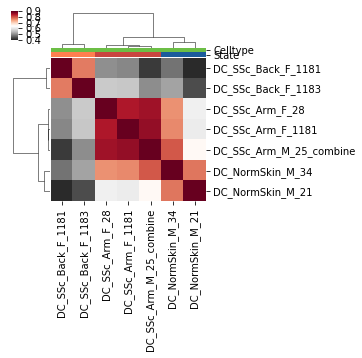

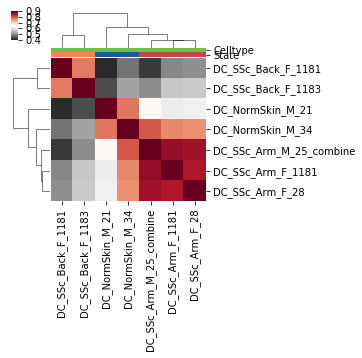

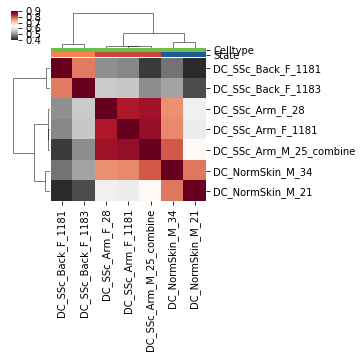

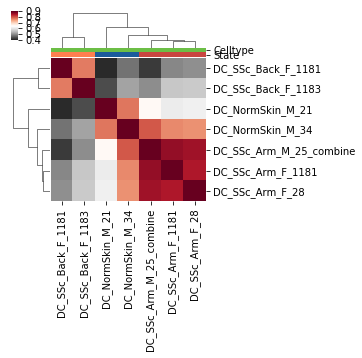

In [143]:
cmap='RdGy_r'
CorHeatmap(FinalDFDC,cmap,os.path.join(DCDir,'All.specificPeaks'),vmin=0.4,vmax=0.9)


In [ ]:
cmap='RdGy_r'
CorHeatmap(FinalDFMac,cmap,os.path.join(MacDir,'All.specificPeaks'),vmin=0.4,vmax=0.9)


In [ ]:
cmap='RdGy_r'
CorHeatmap(FinalDFEC,cmap,os.path.join(ECDir,'All.specificPeaks'),vmin=0.4,vmax=0.9)


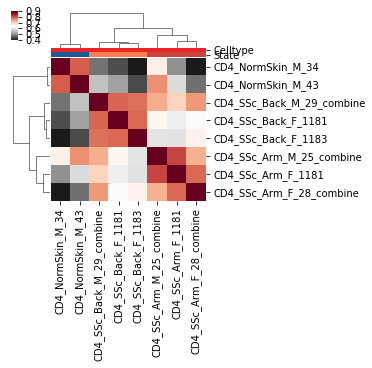

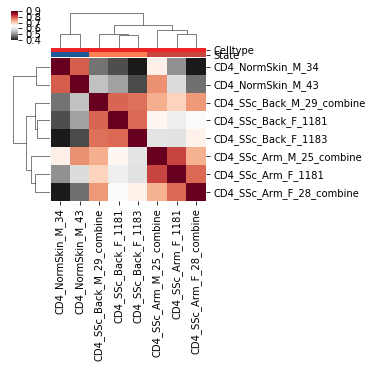

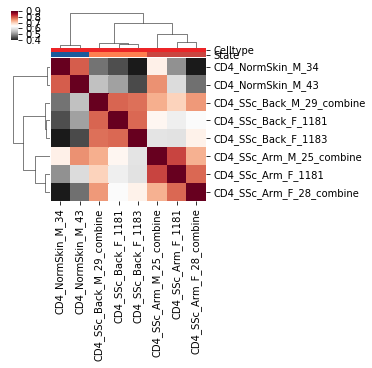

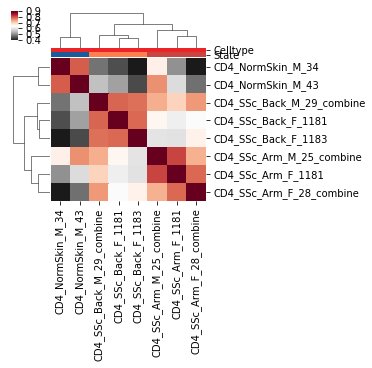

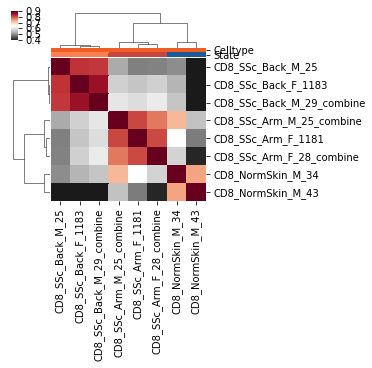

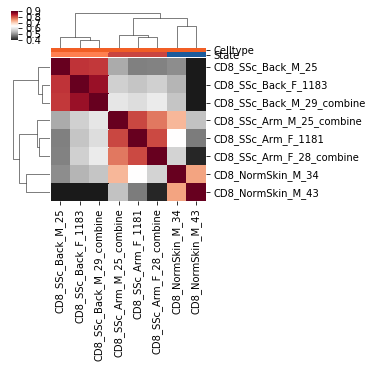

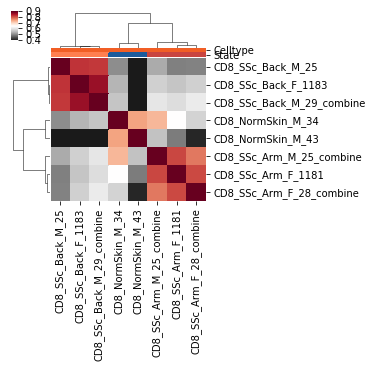

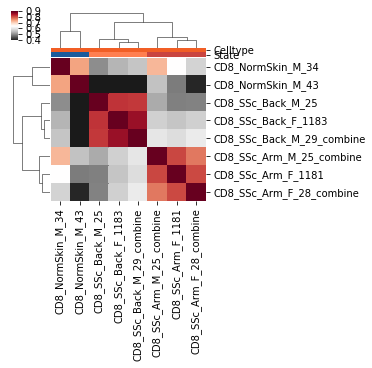

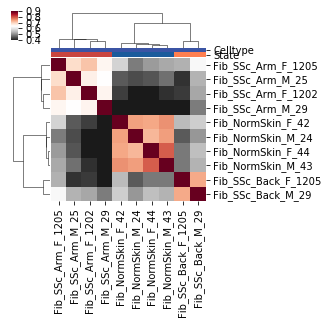

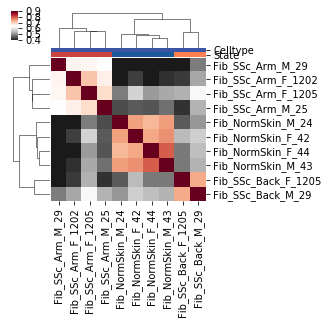

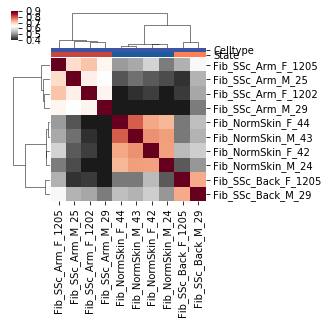

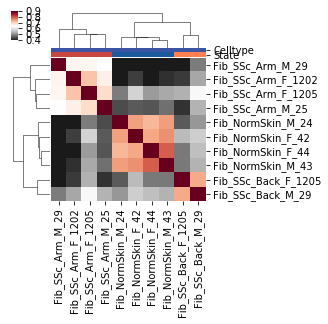

In [144]:


CorHeatmap(FinalDFCD4,cmap,os.path.join(CD4Dir,'All.specificPeaks'),vmin=0.4,vmax=0.9)
CorHeatmap(FinalDFCD8,cmap,os.path.join(CD8Dir,'All.specificPeaks'),vmin=0.4,vmax=0.9)

CorHeatmap(FinalDFFib,cmap,os.path.join(FibDir,'All.specificPeaks'),vmin=0.4,vmax=0.9)



# AnnotatedDiseaseOntology of all peak cluster
Great parameter(Proximal: 
5.0
 kb upstream,  
1.0
 kb downstream, plus Distal: up to 
500.0
 kb)

In [145]:
def GetGO(Dir):
    Dict={}
    List=[i for i in os.listdir(Dir) if 'specificPeaks.shown-OsborneAnnotatedDiseaseOntology.tsv' in i]
    for i in List:
        Dict[i.split('.')[0]]=pd.read_table(os.path.join(Dir,i),sep='\t',skiprows=1,index_col=0)[[' Binom Raw P-Value ']]           
    return Dict
    

In [146]:
DCDict=GetGO(DCDir)
CD4Dict=GetGO(CD4Dir)
CD8Dict=GetGO(CD8Dir)
FibDict=GetGO(FibDir)


In [147]:
def Integration(Dict,Dir):
    AllDis=list(set(flatten([list(Dict[i].index) for i in Dict])))
    print len(AllDis)
    DF=pd.DataFrame({},index=AllDis+[''])
    for i in Dict:
        Dict[i].loc['']=[np.nan]
        DF[i]=Dict[i].loc[AllDis+['']]
    DF=DF.loc[AllDis].dropna(how='all').replace(np.nan,1)
    Save(DF,os.path.join(Dir,'AllDiseaseOntology.Binom_Raw_P-Value.txt'))
    return DF

    

In [148]:
DCDF=Integration(DCDict,DCDir)
CD4DF=Integration(CD4Dict,CD4Dir)
CD8DF=Integration(CD8Dict,CD8Dir)
FibDF=Integration(FibDict,FibDir)




233
88
96
47


In [149]:
DCDF=-DCDF.apply(np.log10)
CD4DF=-CD4DF.apply(np.log10)
CD8DF=-CD8DF.apply(np.log10)
FibDF=-FibDF.apply(np.log10)


In [162]:
StateColorDF=pd.DataFrame(StateColorDict,index=['State']).T

def Clustermap(DF,cmap,File,vmin=None,vmax=None):  
    DF=DF[['Norm','Norm-Back','Back','Arm-Back','Arm','Norm-Arm']]
    fig=sns.clustermap(DF,figsize=(5,0.25*len(DF)),method='average',metric='correlation',col_cluster=False,col_colors=StateColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'AllDiseaseOntology.average.correlation.pdf')
    plt.show()
    
    fig=sns.clustermap(DF,figsize=(5,0.25*len(DF)),method='average',metric='euclidean',col_cluster=False,col_colors=StateColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'AllDiseaseOntology.average.euclidean.pdf')
    plt.show()
    
    fig=sns.clustermap(DF,figsize=(5,0.25*len(DF)),method='complete',metric='correlation',col_cluster=False,col_colors=StateColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'AllDiseaseOntology.complete.correlation.pdf')
    plt.show()
   
    fig=sns.clustermap(DF,figsize=(5,0.25*len(DF)),method='complete',metric='euclidean',col_cluster=False,col_colors=StateColorDF,cmap=cmap,vmin=vmin,vmax=vmax)          
    fig.savefig(File+'AllDiseaseOntology.complete.euclidean.pdf')
    plt.show()
    
    

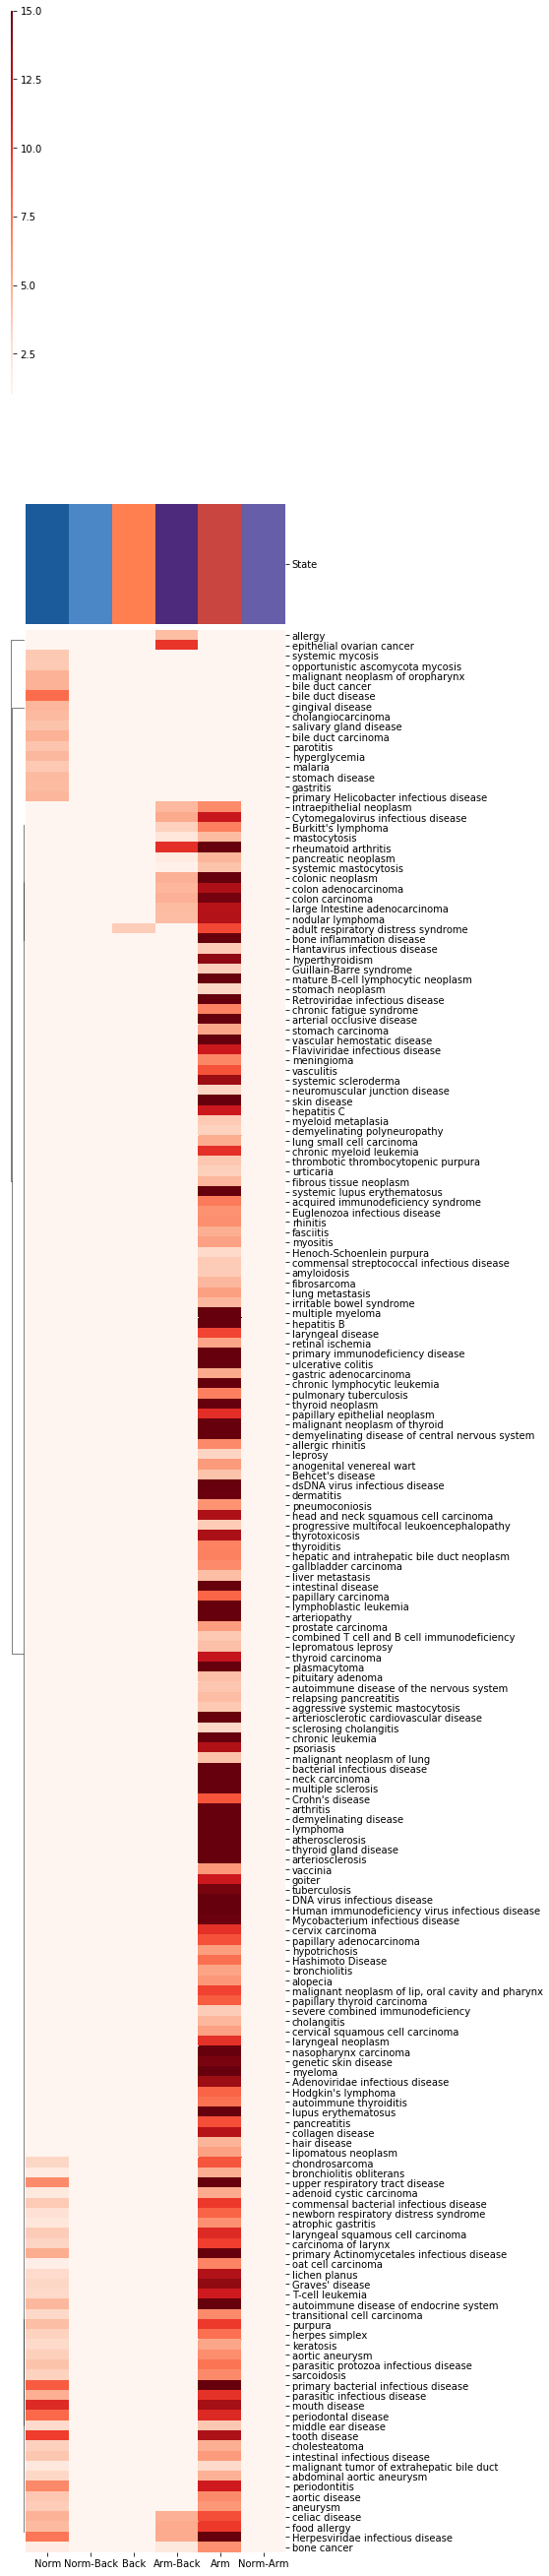

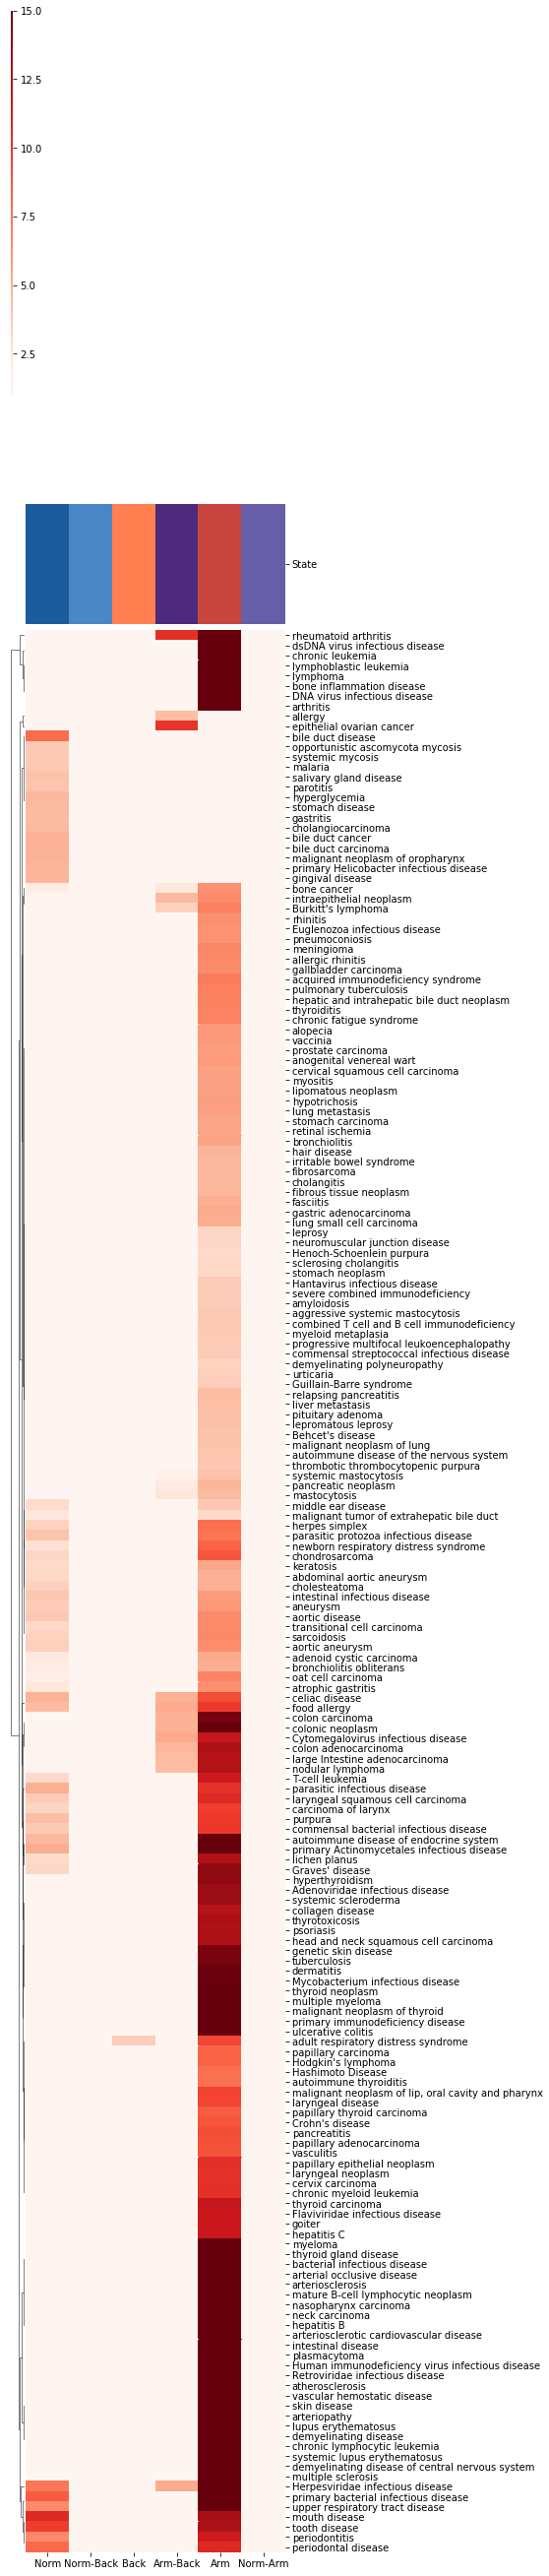

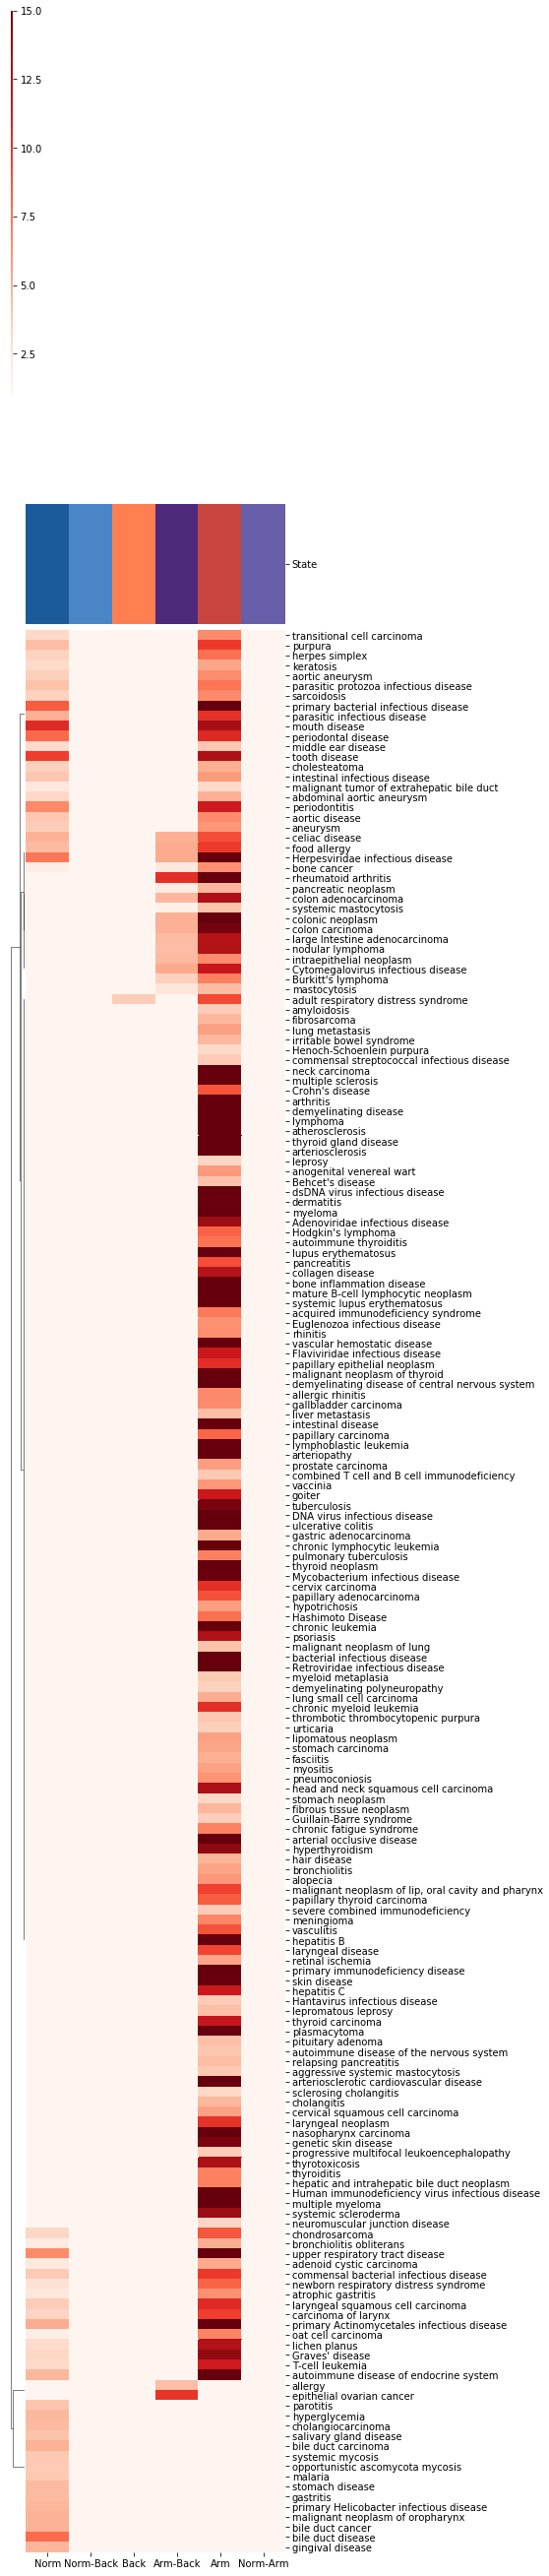

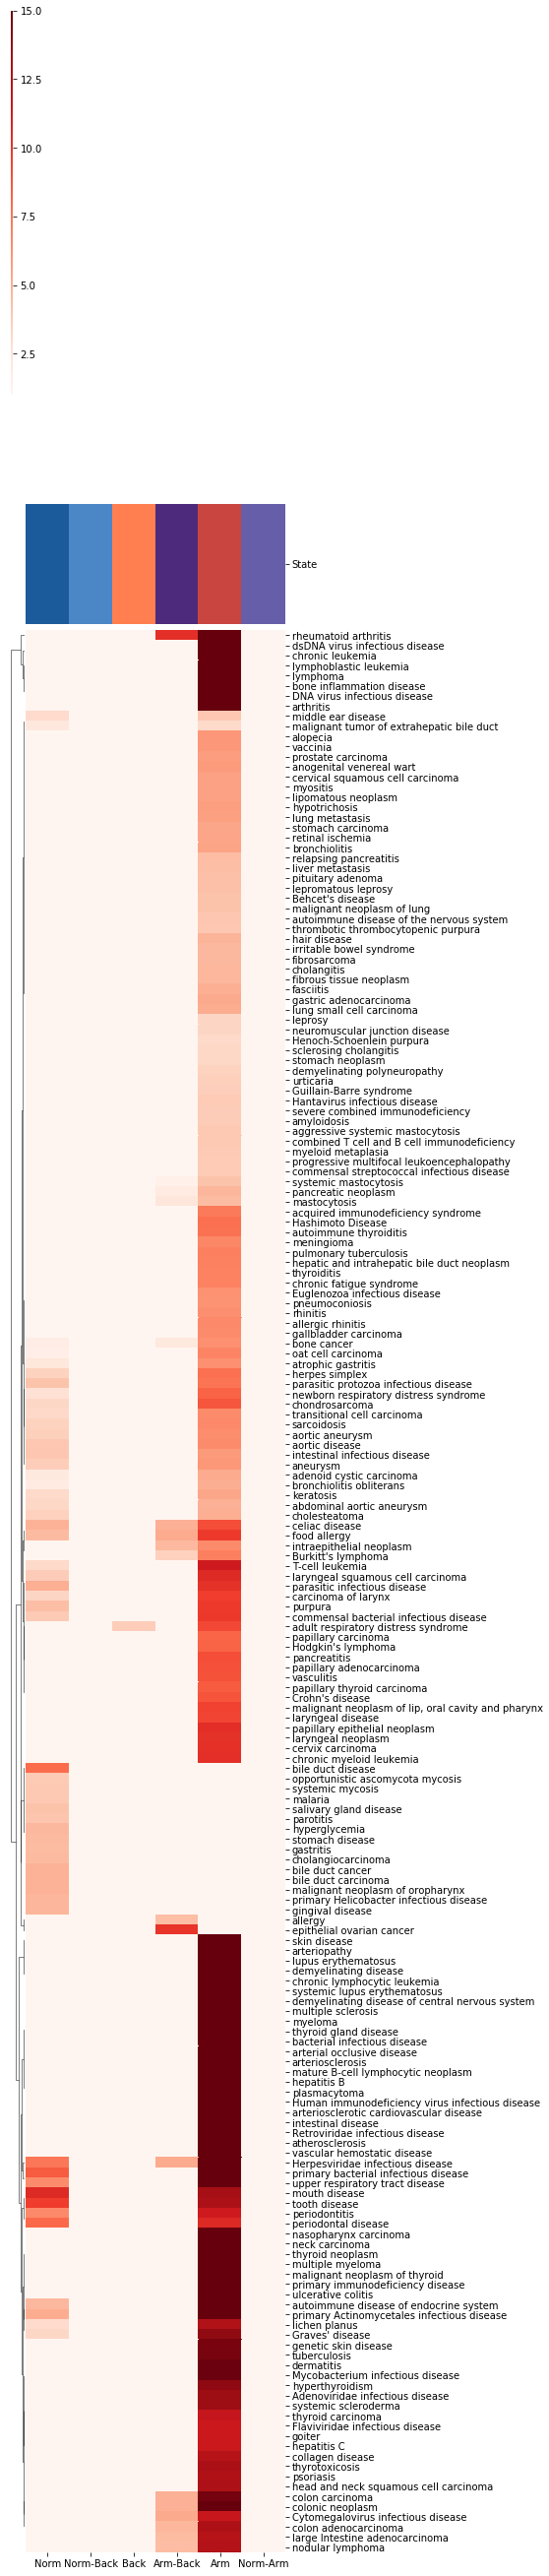

In [163]:
Clustermap(DCDF[DCDF.apply(max,axis=1)>3],'Reds',os.path.join(DCDir,''),vmin=1,vmax=15)



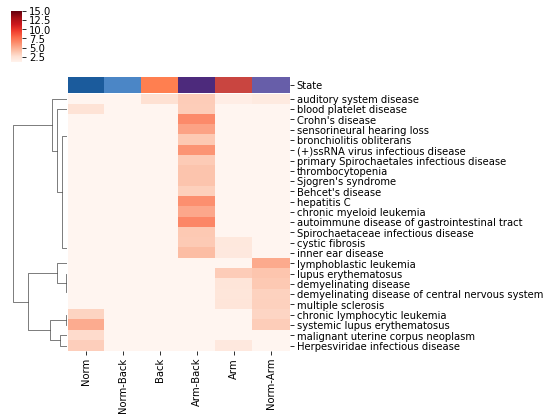

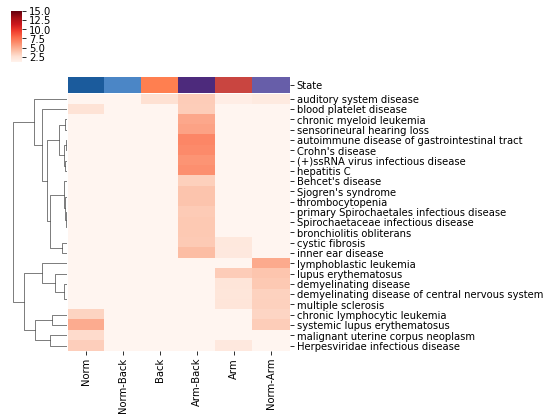

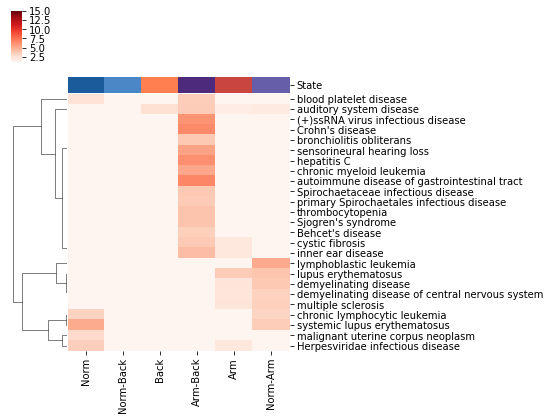

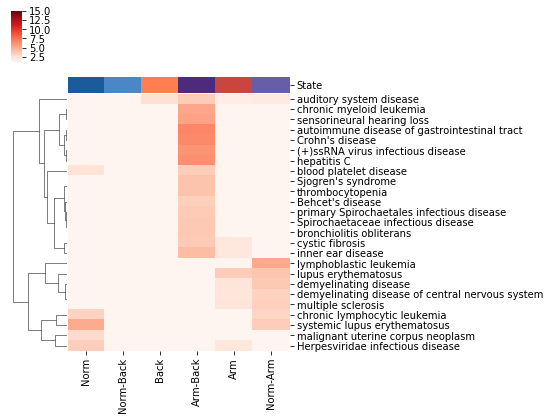

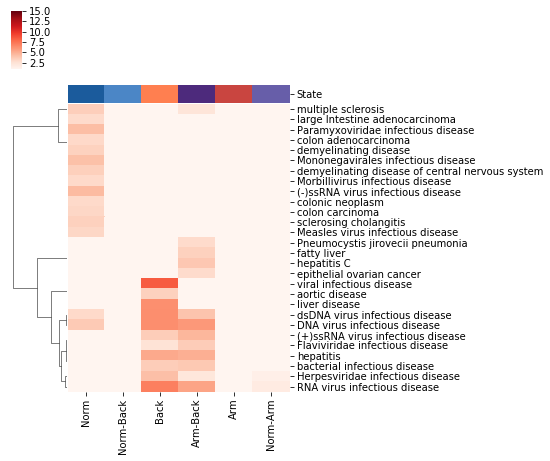

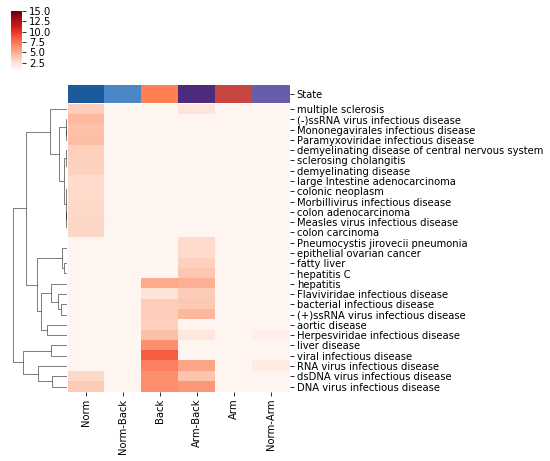

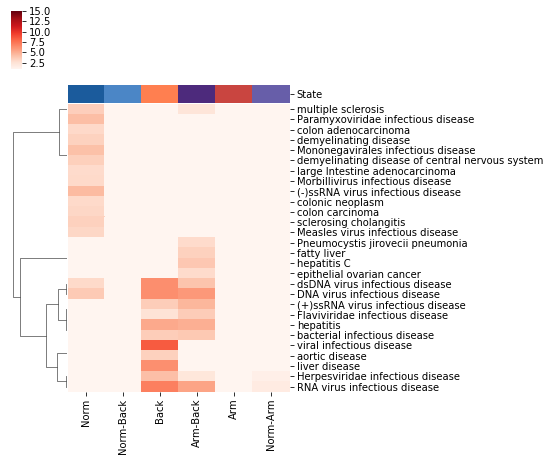

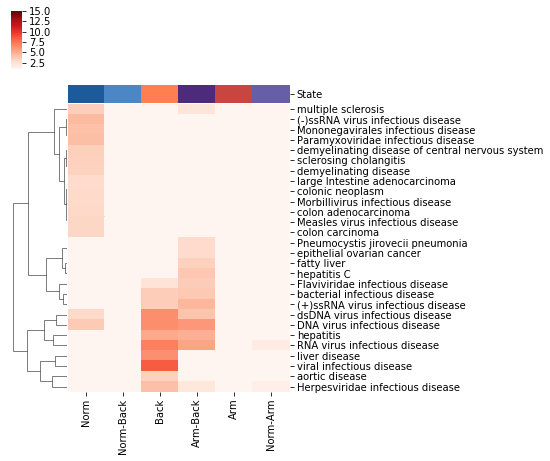

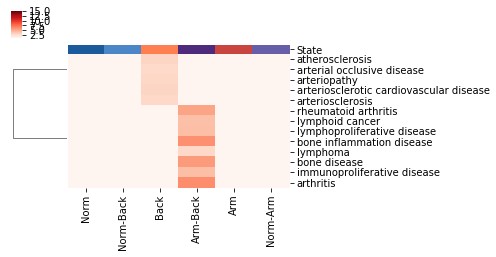

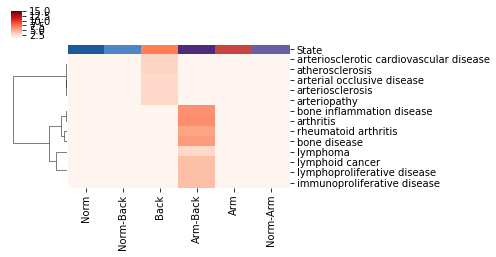

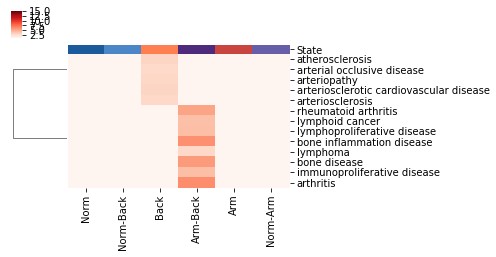

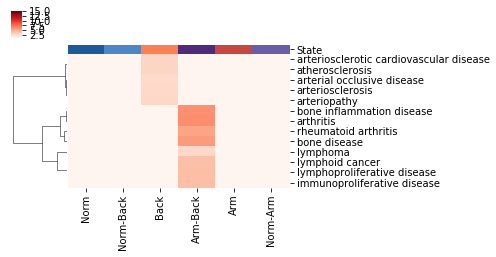

In [164]:

Clustermap(CD4DF[CD4DF.apply(max,axis=1)>3],'Reds',os.path.join(CD4Dir,''),vmin=1,vmax=15)
Clustermap(CD8DF[CD8DF.apply(max,axis=1)>3],'Reds',os.path.join(CD8Dir,''),vmin=1,vmax=15)
Clustermap(FibDF[FibDF.apply(max,axis=1)>3],'Reds',os.path.join(FibDir,''),vmin=1,vmax=15)



# Functional Annotation and spider plot


In [99]:
#首先需要得到基因的调控区域，用jn写的脚本用5，1，300这三个参数
RegDir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/Gene_RegulationRegion_5-1-300/'
Script='/Users/liuqian/Documents/A_Data_analysis/Useful_Script/Python/FromJN_reguMap.py'
Ref='/Users/liuqian/Documents/A_Data_analysis/hg19/hg19_refseq_genes.txt'
Size='/Users/liuqian/Documents/A_Data_analysis/hg19/hg19.sizes'
commend='python {} -d {} -r {} -s {} -m BasalPlusExtend -l 5,1,300'.format(Script,RegDir,Ref,Size)
os.system(commend)


256

In [9]:
#将peak对应基因,上面的步骤可以获得每个基因的调控区域，这一步只需用bedtools intersect把基因对应peak即可
def PeakMapGene(PeakBed,Dir):
    print 'PeakMapGene...'
    BedoutPut='/Users/liuqian/Documents/A_SSC_project/All_Celltype/Gene_RegulationRegion_5-1-300/gene_BasalPlusExtend.bed'      
    Dir2=os.path.join(Dir,'Cluster_GoTerm')
    Mkdir(Dir2)
    Bedfile=PeakBed.split('/')[-1]
    outFile=os.path.join(Dir2,Bedfile+'.ano.Gene.txt')
    Commend='intersectBed -a {} -b {} -wa > {}'.format(BedoutPut,PeakBed,outFile)
    os.system(Commend)
    GeneList=list(ReadBed(outFile)[3])
    return GeneList

#获得所有6个cluster区域的Gene list信息
def GetGeneList(Dir):
    print 'Get Gene list...'
    StateList=['Arm','Arm-Back','Back','Norm-Back','Norm','Norm-Arm']
    FileList=[os.path.join(Dir,st+'.specificPeaks.bed') for st in StateList]
    StateGeneDict={}
    for i in range(len(StateList)):
        print 'Get Gene List for '+StateList[i]
        StateGeneDict[StateList[i]]=PeakMapGene(FileList[i],Dir)
    return StateGeneDict

#获得6个cluster在不同gene list中的p-value以及比例,用超几何分布计算p-value,输出两个DataFrame,一个
def Getpvalue(Dir):
    StateGeneDict=GetGeneList(Dir)
    print 'Get P-value...'
    Dir=os.path.join(Dir,'Cluster_GoTerm')
    Mkdir(Dir)
    GOTerm='/Users/liuqian/Documents/A_Data_analysis/GeneSets_And_GO/MsigDB_GeneSets/GO_BP.bp.v6.1.symbols.gmt'
    #read gmt
    GOTermDict={}
    for line in open(GOTerm).readlines():
        Line=line.rstrip('\n').split('\t')
        GOTermDict[Line[0][3:].lower()]=Line[2:]
    def GetPvalueRatio(L0,L2):
        overlap=sum([1 for i in L0 if i in L2])
        p=-np.log10(scipy.stats.hypergeom.pmf(overlap,23665,len(L2),len(L0)))
        r=float(overlap)/len(L0)
        return p,r
    StateList=['Arm','Arm-Back','Back','Norm-Back','Norm','Norm-Arm']
    GOList=list(GOTermDict)
    PvalueDF=pd.DataFrame({},columns=StateList,index=GOList)
    RatioDF=pd.DataFrame({},columns=StateList,index=GOList)
    for i in StateList:
        print 'Get Enrichment Pvalue for :'+i
        PL=[]
        RL=[]
        for gl in GOList:
            PR=GetPvalueRatio(StateGeneDict[i],GOTermDict[gl])
            PL.append(PR[0])
            RL.append(PR[1])
        PvalueDF[i]=PL
        RatioDF[i]=RL
    F1=PvalueDF.apply(max,axis=1)>2
    PvalueDF=PvalueDF[F1]
    RatioDF=RatioDF[F1]
    Save(PvalueDF,os.path.join(Dir,'GOTerm.Pvalue.txt'))
    Save(RatioDF,os.path.join(Dir,'GOTerm.Ratio.txt'))
    return PvalueDF,RatioDF
    
    
    


In [10]:
ECPvalueDF,ECRatioDF=Getpvalue(ECDir)


Get Gene list...
Get Gene List for Arm
PeakMapGene...
Get Gene List for Arm-Back
PeakMapGene...
Get Gene List for Back
PeakMapGene...
Get Gene List for Norm-Back
PeakMapGene...
Get Gene List for Norm
PeakMapGene...
Get Gene List for Norm-Arm
PeakMapGene...
Get P-value...
Get Enrichment Pvalue for :Arm


/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10


Get Enrichment Pvalue for :Arm-Back
Get Enrichment Pvalue for :Back
Get Enrichment Pvalue for :Norm-Back
Get Enrichment Pvalue for :Norm
Get Enrichment Pvalue for :Norm-Arm


In [141]:

CD4PvalueDF,CD4RatioDF=Getpvalue(CD4Dir)
CD8PvalueDF,CD8RatioDF=Getpvalue(CD8Dir)
DCPvalueDF,DCRatioDF=Getpvalue(DCDir)
FibPvalueDF,FibRatioDF=Getpvalue(FibDir)




Get Gene list...
Get Gene List for Arm
PeakMapGene...
Get Gene List for Arm-Back
PeakMapGene...
Get Gene List for Back
PeakMapGene...
Get Gene List for Norm-Back
PeakMapGene...
Get Gene List for Norm
PeakMapGene...
Get Gene List for Norm-Arm
PeakMapGene...
Get P-value...
Get Enrichment Pvalue for :Arm
Get Enrichment Pvalue for :Arm-Back
Get Enrichment Pvalue for :Back
Get Enrichment Pvalue for :Norm-Back
Get Enrichment Pvalue for :Norm
Get Enrichment Pvalue for :Norm-Arm
Get Gene list...
Get Gene List for Arm
PeakMapGene...
Get Gene List for Arm-Back
PeakMapGene...
Get Gene List for Back
PeakMapGene...
Get Gene List for Norm-Back
PeakMapGene...
Get Gene List for Norm
PeakMapGene...
Get Gene List for Norm-Arm
PeakMapGene...
Get P-value...
Get Enrichment Pvalue for :Arm
Get Enrichment Pvalue for :Arm-Back
Get Enrichment Pvalue for :Back
Get Enrichment Pvalue for :Norm-Back
Get Enrichment Pvalue for :Norm
Get Enrichment Pvalue for :Norm-Arm
Get Gene list...
Get Gene List for Arm
PeakMapGe

/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10


Get Enrichment Pvalue for :Arm-Back
Get Enrichment Pvalue for :Back
Get Enrichment Pvalue for :Norm-Back
Get Enrichment Pvalue for :Norm
Get Enrichment Pvalue for :Norm-Arm
Get Gene list...
Get Gene List for Arm
PeakMapGene...
Get Gene List for Arm-Back
PeakMapGene...
Get Gene List for Back
PeakMapGene...
Get Gene List for Norm-Back
PeakMapGene...
Get Gene List for Norm
PeakMapGene...
Get Gene List for Norm-Arm
PeakMapGene...
Get P-value...
Get Enrichment Pvalue for :Arm
Get Enrichment Pvalue for :Arm-Back
Get Enrichment Pvalue for :Back
Get Enrichment Pvalue for :Norm-Back
Get Enrichment Pvalue for :Norm
Get Enrichment Pvalue for :Norm-Arm


In [11]:
#最后一步画雷达图 color:'Spectral_r'
#下面的参数GOList和ColorList应该是相互对应的两个list,左边的GOList将会对应ColorList中的颜色最终展示在雷达图中
def RadarPlot(Dir,PvalueDF,RatioDF,GOList,ColorList):
    Dir2=os.path.join(Dir,'Cluster_GoTerm')
    Mkdir(Dir2)
    StateList=['Arm','Arm-Back','Back','Norm-Back','Norm','Norm-Arm']
    PvalueDF=PvalueDF[StateList].loc[GOList]
    RatioDF=RatioDF[StateList].loc[GOList]
    
    Angles = np.linspace(0, 2*np.pi, len(StateList), endpoint=False)
    angles = np.concatenate((Angles, [Angles[0]]))
    fig1 = plt.figure(figsize=(5,5))
    ax1 = fig1.add_subplot(111, polar=True)
    
    fig2 = plt.figure(figsize=(5,5))
    ax2 = fig2.add_subplot(111, polar=True)
    
    for i in range(len(GOList)):
        GO=GOList[i]
        Color=ColorList[i]
        dataP=PvalueDF.loc[GO]
        dataR=RatioDF.loc[GO]
        dataR = np.concatenate((dataR, [dataR[0]]))
        dataP=np.concatenate((dataP, [dataP[0]]))
        
        ax1.plot(angles, dataP,color=Color,linestyle='-',label=GO, linewidth=1.5,alpha=0.8)
        
        ax2.plot(angles, dataR,color=Color,linestyle='-',label=GO, linewidth=1.5,alpha=0.8)
        
    ax1.set_thetagrids(angles * 180/np.pi, StateList,fontsize='medium')
    ax1.grid(True,linestyle='--',linewidth =0.5)

    ax2.set_thetagrids(angles * 180/np.pi, StateList,fontsize='medium')
    ax2.grid(True,linestyle='--',linewidth =0.5)
    
    ax1.legend()
    ax2.legend()
    
    fig1File=os.path.join(Dir2,'RadioPlot_ForGOTerm.Pvalue.pdf')
    fig2File=os.path.join(Dir2,'RadioPlot_ForGOTerm.Ratio.pdf')
    
    fig1.savefig(fig1File)
    fig2.savefig(fig2File)
    plt.show()
    
    

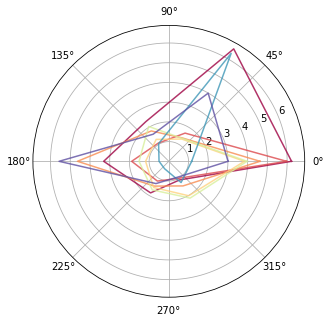

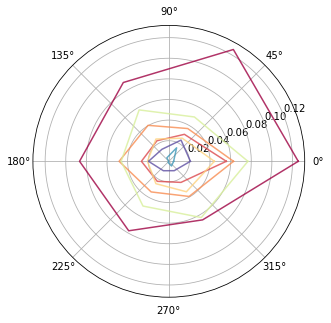

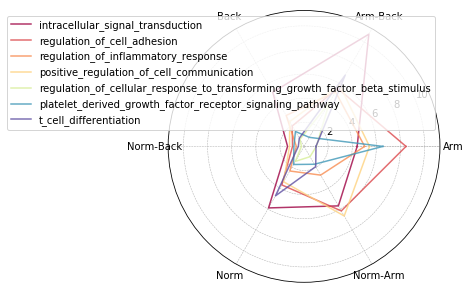

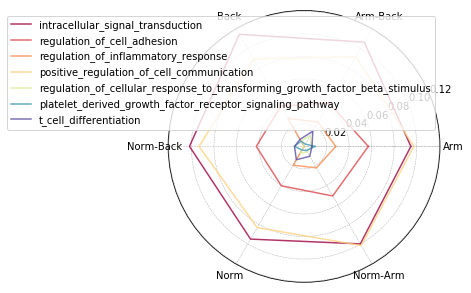

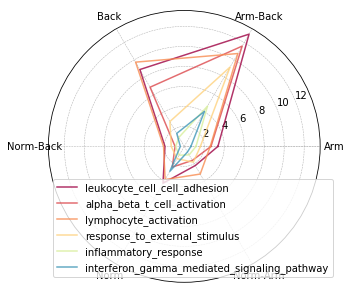

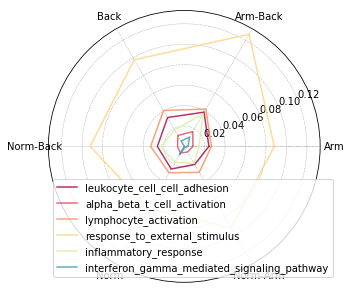

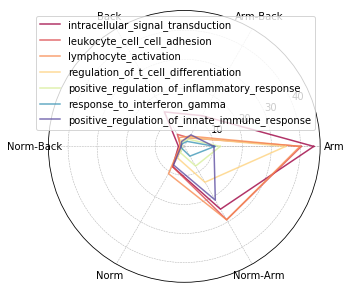

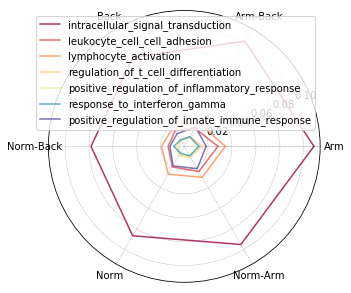

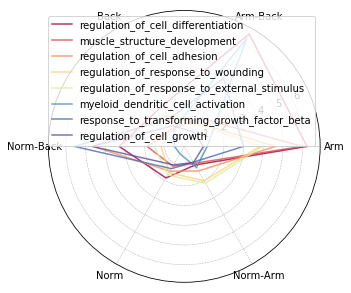

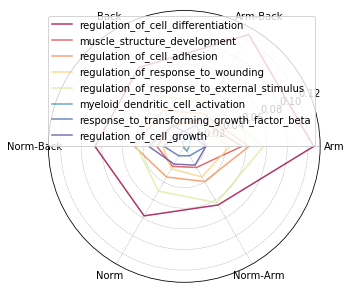

In [175]:


X=sns.color_palette("Spectral_r", 400)
RadarPlot(CD4Dir,CD4PvalueDF,CD4RatioDF,['intracellular_signal_transduction','regulation_of_cell_adhesion','regulation_of_inflammatory_response','positive_regulation_of_cell_communication','regulation_of_cellular_response_to_transforming_growth_factor_beta_stimulus','platelet_derived_growth_factor_receptor_signaling_pathway','t_cell_differentiation'],[X[399],X[350],X[300],X[250],X[150],X[50],X[0]])                           
RadarPlot(CD8Dir,CD8PvalueDF,CD8RatioDF,['leukocyte_cell_cell_adhesion','alpha_beta_t_cell_activation','lymphocyte_activation','response_to_external_stimulus','inflammatory_response','interferon_gamma_mediated_signaling_pathway'],[X[399],X[350],X[300],X[250],X[150],X[50]])
RadarPlot(DCDir,DCPvalueDF,DCRatioDF,['intracellular_signal_transduction','leukocyte_cell_cell_adhesion','lymphocyte_activation','regulation_of_t_cell_differentiation','positive_regulation_of_inflammatory_response','response_to_interferon_gamma','positive_regulation_of_innate_immune_response'],[X[399],X[350],X[300],X[250],X[150],X[50],X[0]])
RadarPlot(FibDir,FibPvalueDF,FibRatioDF,['regulation_of_cell_differentiation','muscle_structure_development','regulation_of_cell_adhesion','regulation_of_response_to_wounding','regulation_of_response_to_external_stimulus','myeloid_dendritic_cell_activation','response_to_transforming_growth_factor_beta','regulation_of_cell_growth'],[X[399],X[350],X[300],X[250],X[150],X[50],X[20],X[0]])





In [179]:
DCtfDir='/Users/liuqian/Documents/A_SSC_project/All_Celltype/DC/Genomica'
DCGxr='/Users/liuqian/Documents/A_SSC_project/All_Celltype/DC/Genomica/DC.gxr.txt'

DCGxrDF=Read(DCGxr)

In [180]:
DCGxrDF

,DC_NormSkin_M_34,DC_NormSkin_M_21,pDC_NormSkin_M_24,DC_SSc_Back_F_1181,DC_SSc_Back_F_1183,DC_SSc_Arm_F_1181,DC_SSc_Arm_F_28,DC_SSc_Arm_M_25_combine
IRF:BATF(IRF:bZIP)/pDC-Irf8-ChIP-Seq(GSE66899)/Homer,5.041720,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"bZIP:IRF(bZIP,IRF)/Th17-BatF-ChIP-Seq(GSE39756)/Homer",14.095612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6.066881
Cdx2(Homeobox)/mES-Cdx2-ChIP-Seq(GSE14586)/Homer,6.583383,0.000000,0.0,0.000000,-8.452203,0.000000,0.000000,16.119764
CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512)/Homer,9.561095,0.000000,0.0,-5.223959,-14.054194,0.000000,0.000000,0.000000
CEBP(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512)/Homer,12.376693,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
E2F1(E2F)/Hela-E2F1-ChIP-Seq(GSE22478)/Homer,-10.804098,0.000000,0.0,21.322887,6.857405,0.000000,0.000000,-6.254267
E2F3(E2F)/MEF-E2F3-ChIP-Seq(GSE71376)/Homer,-7.965498,0.000000,0.0,28.034113,16.699917,0.000000,0.000000,-15.111243
E2F4(E2F)/K562-E2F4-ChIP-Seq(GSE31477)/Homer,-7.012992,0.000000,0.0,17.437630,12.388787,-8.309773,0.000000,-13.973639
E2F6(E2F)/Hela-E2F6-ChIP-Seq(GSE31477)/Homer,-7.087595,0.000000,0.0,28.153234,15.687003,0.000000,0.000000,-15.551411
E2F7(E2F)/Hela-E2F7-ChIP-Seq(GSE32673)/Homer,-7.730573,0.000000,0.0,11.233885,0.000000,0.000000,0.000000,0.000000


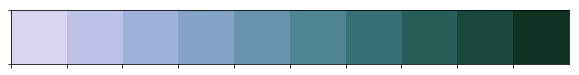

In [17]:
sns.palplot(sns.cubehelix_palette(10, start=-7))
plt.show()